This notebook is the record of how I built a simple artificial bat call detector. I see that MacAodha et al. 2018 have a really cool dataset that predicts the presence of multiple bat calls in an audio recording. However, after brief tests with my current Orlova Chuka dataset, I see that the neural network is not really equipped to handle 'busy' recordings with multiple bat calls in a few milliseconds - which is basically most of my data. To allow fast and robust detection of bat cals in such busy situations, I need to develop a separate detector it looks like. 

What I'm planning to do is to essentially break the problem into two parts:
1) training a network to detect the presence of a single bat call in a short timespan recording (10ms)
    > the network will be trained on artificially generated bat-like calls 
2) running this network on real data to see if it works 
3) figuring out how to output temporal localisation information from this network. 

### The Training and Testing dataset : 
The training and testing dataset will have two types of audio snippets : 
#### > bat like call : FM sweeps of varying frequency ranges, durations, amplitude windowing, SNR etc., *maybe even CF sweeps?..*
#### > non-bat like call : all kinds of sounds that are *not* bat calls, sounds in the audible range, upward FM sweeps, noise with same frequency structure as bat like call, time scrambled version of a bat like call, FM sweeps in audbile range, impulsive sounds with the same time-frequency structure as a bat call 

My idea is essentially that if I can train a network to distinguish a bat call from a non-bat call this can then be used as a learning ground to know what works and what doesn't work. I'm also hoping that any network trained on such a large variety of bat+non-bat like calls should be able to generalise onto the real data itself ! 

As of now I understand that object localisation first depends on having a working detector network first! This detector network is then in turn used to predict the probabilities of the object/s being placed in various parts of the network. Thus, this detector network is the first step in building a network that actually labels the start and end time of a bat call in an audio recording. 


2018-09-19: 

#### Generating the training + test datasets.
As of now I'm taking a very quick and dirty approach - a little bit unsettling, but I know this is exactly what's needed to get my proof of concept bat call detection network started. I'm planning to use the spectrograms of the audio for call detection, just like the batdetect network. 

I've written some quick code that generates 10 millisecond audio snippets with:
* various types of FM chirps with high-low frequency sweeps with varying:
    * start and end frequencies 
    * durations 
    * SNRs
    * background noise level 
    * 'shape' (linear/hyperbolic/logarithmic)

* A whole variety of non-bat like sounds : 
    * low-high frequency chirps 
    * continuous noise
    * bat-like calls in the audible frequency range 
Hopefully, these examples right now should already be enough to train the network. 

#### Final output of the spectrograms from the audio snippets : 
I'm still considering what kind of spectrogram shape to feed into the network. The final input dimensions to the network should be : 
* training_images : Numtraining_samples x Nrow x Ncolumns , training_labels : 1 x Numtraining_samples

At this point I'm not yet sure what spectrogram parameters to feed into the network - and so perhaps I'll just create all of the audio files with the proper labels right now. 

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
import numpy as np 
import pandas as pd
import random
import scipy.signal as signal 
import time

from make_training_data import generate_a_samplesound, mean_subtract_rowwise, generate_noise_as_samplesound

In [2]:
def make_one_sample_sound(startfreq_range, endfreq_range, noise=False):
    '''
    
    Creates a bat-like FM chirp and returns the signal array + 
    the spectrogram of the signal array after band-wise mean subtraction.
    
    '''
    
    SNRs = np.arange(-2,50)
    bg_noise_dB = np.arange(-80, -6)

    shapes = ['linear', 'hyperbolic', 'logarithmic']
    durations = np.linspace(0.001, 0.009, 10)

    fft_winsize = 64
    fft_winoverlap = 32
  
    file_timestamp  = str(int(time.time()*10**6))

    bg_noise = np.random.choice(bg_noise_dB, 1)

    
    if not noise:
        rand_durn = np.random.choice(durations,1)
        rand_shape = random.choice(shapes)
        start_freq = np.random.choice(startfreq_range, 1)
        end_freq = np.random.choice(endfreq_range, 1)
        rand_snr = np.random.choice(SNRs, 1)

        one_sound = generate_a_samplesound(rand_durn,fs=192000, freqs=[start_freq, end_freq],
                                   background_noise=bg_noise, SNR=rand_snr)
        
    else:
        one_sound = generate_noise_as_samplesound(bg_noise)
    f,t, s= signal.spectrogram(one_sound, fs=192000, nperseg=fft_winsize, noverlap=fft_winoverlap);
    flipped_s = np.flipud(s)
    spect_image = mean_subtract_rowwise(flipped_s)
    # now normalise by highest value:
    norm_spect_image = spect_image/np.max(spect_image)

    return(one_sound, norm_spect_image, file_timestamp)



In [3]:
def  make_some_batcalllike_files(num_files):
    audio_file_dict = {}
    startfreq_range = np.arange(95000, 60000, -1)
    endfreq_range = np.arange(50000, 20000, -1)
    for k in range(num_files):
        snippet, spect_im, filename = make_one_sample_sound(startfreq_range, endfreq_range)
        audio_file_dict[filename] = {'audio':snippet, 'image':spect_im, 'batlike':1}
    return(audio_file_dict)

In [4]:
def  make_some_ultrasonic_upwardFM_files(num_files):
    audio_file_dict = {}
    startfreq_range = np.arange(20000, 50000, 1)
    endfreq_range =  np.arange(60000, 95000, 1)
    for k in range(num_files):
        snippet, spect_im, filename = make_one_sample_sound(startfreq_range, endfreq_range)
        audio_file_dict[filename] = {'audio':snippet, 'image':spect_im, 'batlike':0}
    return(audio_file_dict)

In [5]:
def  make_some_audible_FM_files(num_files):
    audio_file_dict = {}
    startfreq_range = np.arange(10000, 20000, 1)
    endfreq_range = np.arange(5000, 1, -1)
    for k in range(num_files):
        snippet, spect_im, filename = make_one_sample_sound(startfreq_range, endfreq_range)
        audio_file_dict[filename] = {'audio':snippet, 'image':spect_im, 'batlike':0}
    return(audio_file_dict)

In [6]:
def make_some_noise_files(num_files):
    audio_file_dict = {}
    startf = None
    endf = None
    for k in range(num_files):
        snippet, spect_im, filename = make_one_sample_sound(startf, endf,noise=True)
        audio_file_dict[filename] = {'audio':snippet, 'image':spect_im, 'batlike':0}
    return(audio_file_dict)

In [7]:
nfiles = 1000
# make all the non-bat like sound snippets 
noise_file_dict = make_some_noise_files(nfiles)
audiblefm_file_dict = make_some_audible_FM_files(nfiles)
ultrsonic_upFM_dict = make_some_ultrasonic_upwardFM_files(nfiles)
# make all the bat-like sound snippets
batlike_dict = make_some_batcalllike_files(nfiles*4)

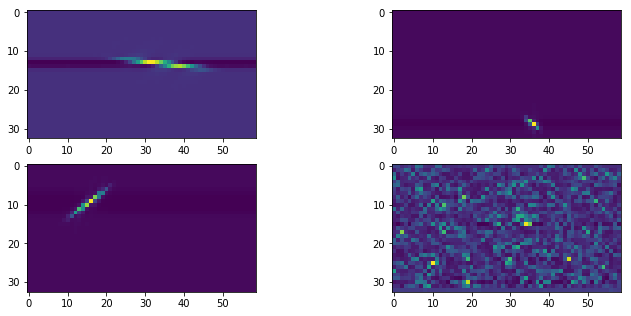

In [8]:
eg1 = batlike_dict[batlike_dict.keys()[8]]['image']
eg2 = audiblefm_file_dict[audiblefm_file_dict.keys()[8]]['image']
eg3 = ultrsonic_upFM_dict[ultrsonic_upFM_dict.keys()[8]]['image']
eg4 = noise_file_dict[noise_file_dict.keys()[8]]['image']

plt.figure(figsize=(12,8))
plt.subplot(321); plt.imshow(eg1)
plt.subplot(322); plt.imshow(eg2)
plt.subplot(323); plt.imshow(eg3)
plt.subplot(324); plt.imshow(eg4)

2018-09-20 : 
Today I'm actually going to put together all of the simulated data and begin assembling the network to train. I'm hoping I'll at least understand whether this task is achievable at all :P. 
Looking at the MNIST dataset format in Keras, I can see the end datasets needs to be a 3d matrix. I would essentially put together all of the spectrogram outputs into one 3d matrix, and then shuffle the rows a bit to avoid any kind of bias in the parameter estimation (eg. if all the +ve samples are placed first, followed by the -ve samples, this maybe perhaps could cause issues with the training as the network goes through one pass of all samples). 

In [9]:
# put all the sample spectrograms and the labels together. 
total_num_files = sum([ len(one_dict.keys()) for one_dict in [noise_file_dict, audiblefm_file_dict,ultrsonic_upFM_dict,
                                                              batlike_dict] ])

nrows_image, ncols_image =   batlike_dict[batlike_dict.keys()[0]]['image'].shape

In [10]:
image_tensor = np.zeros((total_num_files, nrows_image, ncols_image))
image_labels = np.zeros(total_num_files)

image_num = 0
for each_dict in [noise_file_dict, audiblefm_file_dict, ultrsonic_upFM_dict, batlike_dict]:    
    for key,item in each_dict.iteritems():
        image_tensor[image_num,:,:] = item['image']        
        image_labels[image_num] = item['batlike']
        image_num += 1 

In [11]:
# shuffle around the data and separate them into training and testing datasets 
nonbatlike_indices = np.argwhere(image_labels==0).flatten()
batlike_indices = np.argwhere(image_labels==1).flatten()

positive_and_negative_inds = []
# take out 75% of the +ve and -ve samples for training and keep 25% aside for testing:
for inds in [batlike_indices, nonbatlike_indices]:
    training_size = int(0.75*inds.size)
    all_inds = set(inds)
    training_inds = set(np.random.choice(inds, training_size, replace=False))
    # find the indices that were not chosen randomly and assign them to the testing dataset 
    testing_inds = all_inds - training_inds
    positive_and_negative_inds.append([training_inds, testing_inds])
    


In [28]:
positive_training_rowinds = np.array(list(positive_and_negative_inds[0][0]))
positive_testing_rowinds = np.array(list(positive_and_negative_inds[0][1]))
negative_training_rowinds = np.array(list(positive_and_negative_inds[1][0]))
negative_testing_rowinds = np.array(list(positive_and_negative_inds[1][1]))

positive_training_imgs = image_tensor[positive_training_rowinds,:,:]
positive_testing_imgs = image_tensor[positive_testing_rowinds,:,:]
negative_training_imgs = image_tensor[negative_training_rowinds,:,:]
negative_testing_imgs = image_tensor[negative_testing_rowinds,:,:]

positive_training_labels = image_labels[positive_training_rowinds]
positive_testing_labels = image_labels[positive_testing_rowinds]
negative_training_labels = image_labels[negative_training_rowinds]
negative_testing_labels = image_labels[negative_testing_rowinds]

# put it all together into two separate datasets and shuffle them again one last time : 
alltraining_imgs_serial = np.row_stack((positive_training_imgs, negative_training_imgs))
alltraining_labels_serial = np.concatenate((positive_training_labels, negative_training_labels))

ind_shuffle_training = np.random.choice(range(alltraining_imgs_serial.shape[0]),
                                        alltraining_imgs_serial.shape[0],replace=False)
training_imgs = alltraining_imgs_serial[ind_shuffle_training,:,:]
training_labels = alltraining_labels_serial[ind_shuffle_training]

testing_imgs = np.row_stack((positive_testing_imgs, negative_testing_imgs))
testing_labels = np.concatenate((positive_testing_labels, negative_testing_labels))


In [29]:
import pickle

In [30]:
# let's also save all of this data in a nice format somewhere so that i can possible continue working on this data 
# with a separate notebook
training_data = (training_imgs, training_labels)
testing_data = (testing_imgs, testing_labels)

all_data = {'training':training_data, 'testing':testing_data}

file = open('batlike_data.pkl','wb')
pickle.dump(all_data, file)
file.close()

### Let's stop right here and begin another notebook which actually deals with building a network from the current dataset we just created. 